In [58]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts
from utils.lorenz import load_lorenz96_2coupled

import numpy as np
import jax.numpy as jnp

In [60]:
import ml_collections

config = ml_collections.ConfigDict()

# Data params. 
config.n_samples=10000
config.input_steps=1
config.output_delay=0 # predict 0 hours into the future
config.output_steps=12
config.timestep_duration=3
config.sample_buffer=-1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
config.time_resolution=120
config.init_buffer_samples=0
config.train_pct=0.7
config.val_pct=0.2
config.test_pct=0.1
config.K=36
config.F=8
config.c=10
config.b=10
config.h=1
config.seed=42
config.normalize=True
config.fully_connected_edges=False

# Optimizer.
config.optimizer = 'sgd'
config.learning_rate = 0.00045346796177033903
config.momentum = 0.8712873602503628

# Training hyperparameters.
# config.batch_size = 3
config.epochs = 150
config.log_every_epochs = 5
config.eval_every_epochs = 5
config.checkpoint_every_epochs = 10
config.max_checkpts_to_keep = None # None means keep all checkpoints

# GNN hyperparameters.
config.model = 'MLPGraphNetwork'
config.n_blocks = 1
config.activation = 'relu'
config.dropout_rate = 0.013287043114620523
config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config.layer_norm = False # TODO perhaps we want to turn on later
config.edge_features = (8, 8) # the last feature size will be the number of features that the graph predicts
config.node_features = (32, 2)
config.global_features = None
config.share_params = False

In [61]:
from utils.jraph_training import train_and_evaluate
from utils.jraph_vis import plot_predictions

In [62]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [63]:
workdir="tests/outputs/long_rollout_5"

trained_state, train_metrics, eval_metrics_dict, _ = train_and_evaluate(
    config=config, workdir=workdir)


INFO:absl:Obtaining datasets.
INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.013287043114620523, 'edge_features': (8, 8), 'epochs': 150, 'eval_every_epochs': 5, 'fully_connected_edges': False, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.00045346796177033903, 'log_every_epochs': 5, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'momentum': 0.8712873602503628, 'n_blocks': 1, 'n_samples': 10000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'sgd', 'output_delay': 0, 'output_steps': 12, 'sample_buffer': -12, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                 

2 checkpoints logged runtime: 2m 27s
all checkpoints logged runtime: 2m 25s

no difference between logging every checkpoint/only logging the last 2. gpu issues probably stem from somewhere else

INFO:root:Generating datasets from config because none provided.


Checkpoint directory: tests/outputs/long_rollout_3/checkpoints


INFO:root:Initializing network.
INFO:absl:
+----------------------------------------+--------+------+---------+-------+
| Name                                   | Shape  | Size | Mean    | Std   |
+----------------------------------------+--------+------+---------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (4,)   | 4    | 0.0     | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 4) | 24   | -0.0819 | 0.36  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (2,)   | 2    | 0.0     | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (4, 2) | 8    | 0.289   | 0.469 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (2,)   | 2    | 0.0     | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (7, 2) | 14   | -0.159  | 0.305 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)   | 2    | 0.0     | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (2, 2) | 4    | -0.141  | 0.582 |
| params/MLPBlock_1/MLP_0/Dense_0/bias   | (4,)   | 4    | 0.0     | 0.0   |
| params/MLPBlock_1/MLP_0/Dense_0

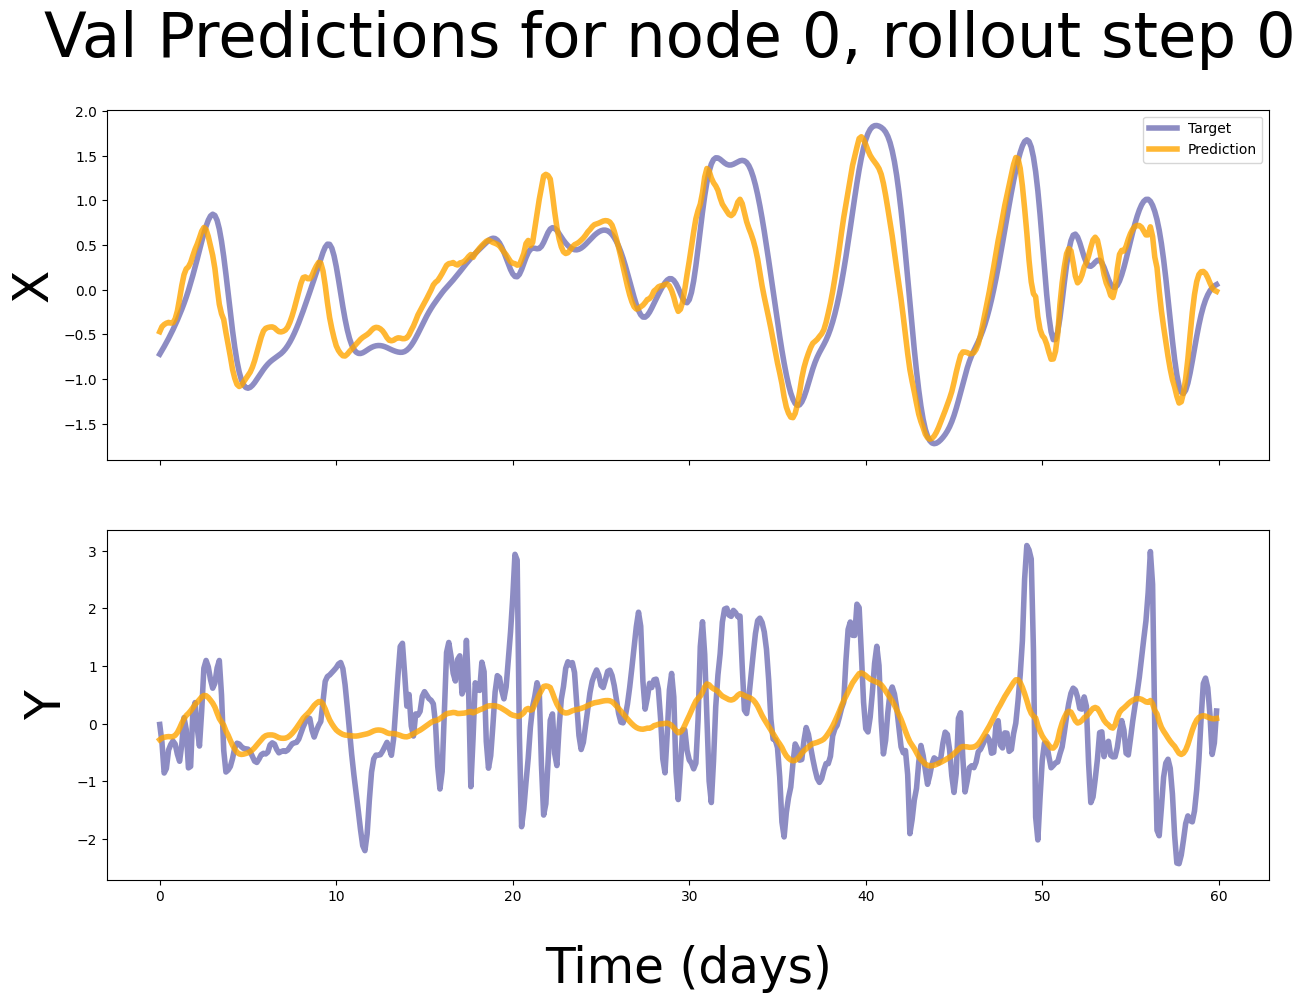

In [ ]:
plot_predictions(
    config=config,
    workdir=workdir, # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    plot_days=60,
    title="Val Predictions for node 0, rollout step 0"
)

In [ ]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state



In [ ]:
# datasets = create_dataset(config=config)

In [ ]:
def plot_predictions_multirollout(
    config,
    workdir, # for loading checkpoints 
    node, # 0-indexed 
    plot_mode, # i.e. "train"/"val"/"test"
    datasets=None,
    plot_days=None, # if None, plot entire time series; otherwise plot specified number of days 
    title=''):
    assert plot_mode in ["train", "val", "test"]

    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    assert os.path.exists(checkpoint_dir)

    # samples must be overlapping and consecutive for this plot to really be interpretable the way it is meant 
    assert (
        config.input_steps + config.output_delay + config.output_steps + config.sample_buffer == 1
        )

    # Get datasets, organized by split.
    if datasets is None:
        logging.info('Generating datasets from config because none provided.')
        datasets = create_dataset(config)

    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    target_data = plot_set['targets']
    # n_rollout_steps = config.output_steps

    # Create the evaluation state, corresponding to a deterministic model.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = input_data[0]
    eval_net = create_model(config, deterministic=True)
    params = jax.jit(eval_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer and state.
    # (we don't actually need the optimizer for evaluation, we just need it to create the state)
    tx = create_optimizer(config)
    state = train_state.TrainState.create(
        apply_fn=eval_net.apply, params=params, tx=tx
    )

    # load the checkpoint state
    ckpt = checkpoint.Checkpoint(checkpoint_dir)
    state = ckpt.restore(state) # restore latest checkpoint 

    # get the predictions from the model for the ith step of the rollout and for the specified node
    node_preds_all_rollouts = []
    node_targets = []

    # loop over individual windows in the dataset 
    # TODO try batching to see if its faster? 

    if plot_days is not None:
        plot_count = plot_days * config.time_resolution / 5 / config.timestep_duration
    else:
        plot_count = len(input_data)

    for i, (input_window_graphs, target_window_graphs) in enumerate(zip(
        input_data, target_data)):
        if i >= plot_count:
            break
        pred_nodes_list = rollout(state=state,
                                  input_window_graphs=input_window_graphs,
                                  n_rollout_steps=config.output_steps,
                                #   n_rollout_steps=plot_ith_rollout_step+1, # +1 since plot_ith_rollout_step is 0-indexed
                                  rngs=None) # deterministic during eval
        
        # get the last array of predictions, which will correspond to the ith rollout step that we care about 
        # ith_rollout_pred = pred_nodes_list[plot_ith_rollout_step]
        # node_pred = ith_rollout_pred[node, :] # jnp array with shape (1, 2)
        node_preds_all_rollouts.append([ith_rollout_pred[node, :] for ith_rollout_pred in pred_nodes_list])

        # also grab the target nodes while we're in this loop 
        # ith_rollout_target = target_window_graphs[plot_ith_rollout_step].nodes
        node_target = target_window_graphs[0].nodes[node, :] # jnp array with shape (1, 2)
        node_targets.append(node_target)
        # node_targets.append([ith_rollout_target.nodes[node, :] for ith_rollout_target in target_window_graphs])

    node_preds_all_rollouts = np.array(node_preds_all_rollouts) # shape (len(t_days), output_steps, 2)
    node_targets = np.array(node_targets) # shape (len(t_days), 2)

    # reconstruct timesteps
    steps = np.arange(plot_count)
    # convert timesteps from step index to day 
    t_days = steps * config.timestep_duration * 5 / config.time_resolution 

    # set up plot
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
    if title == '':
        fig.suptitle(f"{plot_mode} predictions for node {node}", size=28)
    else:
        fig.suptitle(title, size=28)
    ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
                  size=20)
    ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node),
                  size=20)
    plt.xlabel('time (days)', size=16)

    # plot rollout targets
    ax0.plot(
        t_days,
        node_targets[:, 0],
        # s=5,
        alpha=0.8,
        label='targets',
        c='blue')
    ax1.plot(
        t_days,
        node_targets[:, 1], 
        alpha=0.8, 
        label='targets', 
        c='blue')

    # plot predictions
    for i in range(config.output_steps):
        rollout_steps = np.arange(i, plot_count + i)
        t_days_rollout = rollout_steps * config.timestep_duration * 5 / config.time_resolution 
        ax0.plot(
            t_days_rollout,
            node_preds_all_rollouts[:, i, 0],
            # s=5,
            alpha=0.8,
            label=f'rollout {i}')
        ax1.plot(
            t_days_rollout,
            node_preds_all_rollouts[:, i, 1],
            # s=5,
            alpha=0.8,
            label=f'rollout {i}')

    ax0.legend()
    ax1.legend()


In [ ]:
def plot_longitudinal(
    state, 
    config, 
    version, 
    plot_ith_rollout_step, 
    plot_mode, 
    datasets, 
    plot_days,
    title=None,
):
    assert version in ["target", "predicted", "diff"]
    assert plot_mode in ["train", "val", "test"]

    # set up data 
    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    target_data = plot_set['targets']

    plot_count = plot_days * config.time_resolution / 5 / config.timestep_duration

    target_timeseries = []
    pred_timeseries = []
    diff_timeseries = []

    # reconstruct timesteps
    steps = np.arange(plot_count)
    # convert timesteps from step index to day 
    t_days = steps * config.timestep_duration * 5 / config.time_resolution 

    for i, (input_window_graphs, target_window_graphs) in enumerate(zip(
        input_data, target_data)):
        if i >= plot_count:
            break

        if version in ["predicted", "diff"]:
            # get predicted data 
            pred_nodes_list = rollout(state=state,
                                    input_window_graphs=input_window_graphs,
                                    n_rollout_steps=config.output_steps,
                                    rngs=None) # deterministic during eval
            
            # get the last array of predictions, which will correspond to the ith rollout step that we care about 
            ith_rollout_pred = pred_nodes_list[plot_ith_rollout_step]
            pred_timeseries.append(ith_rollout_pred)

        if version in ["target", "diff"]:
            # get original data 
            ith_rollout_target = target_window_graphs[plot_ith_rollout_step].nodes
            target_timeseries.append(ith_rollout_target)

        if version == "diff":
            # get diff
            diff_timeseries.append(ith_rollout_pred - ith_rollout_target) 
    
    if version == "target":
        timeseries_to_plot = np.array(target_timeseries)
    elif version == "predicted":
        timeseries_to_plot = np.array(pred_timeseries)
    elif version == "diff":
        timeseries_to_plot = np.array(diff_timeseries)
    # these have shape (len(t_days), 36, 2)

    lon=np.arange(180,-180,-360/config.K)

    xmin = min(lon)
    xmax = max(lon)
    ymin = min(t_days)
    ymax = max(t_days)

    # create plot
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 14), sharex=True, sharey=True)
    X1 = timeseries_to_plot[:, :, 0]
    X2 = timeseries_to_plot[:, :, 1]

    # set colormaps and min/max values for the color bar 
    if version == "diff":
        cmap1 = "RdBu_r"
        cmap2 = "RdBu_r"
        # vmin = 
    else:
        cmap1 = "PiYG_r"
        cmap2 = "PuOr_r"
    # plot x1
    x1_plot = ax0.imshow(X1,
            extent=[xmin, xmax, ymin, ymax], 
            origin='lower', 
            cmap=cmap1,
            alpha=0.5,
            aspect='auto', 
            vmin=-2,
            vmax=2,
            # vmin=-np.percentile(X1, .9), 
            # vmax=np.percentile(X1, .9)
            )
    fig.gca().invert_yaxis() 
    
    # plot x2
    x2_plot = ax1.imshow(X2,
            extent=[xmin, xmax, ymin, ymax], 
            origin='lower', 
            cmap=cmap2,
            alpha=0.5,
            aspect='auto', 
            vmin=-2,
            vmax=2,
            # vmin=-np.percentile(X2, .9), 
            # vmax=np.percentile(X2, .9)
            )
    fig.gca().invert_yaxis() 
    
    ax1.set_ylabel('Time (days)', fontsize=35)
    ax1.yaxis.set_label_coords(-0.1,1) # move to be centered vertically 

    ax1.set_xlabel('Longitude', fontsize=35, labelpad=20)
    plt.rc('axes', labelsize=35)
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=22)
    fig.colorbar(x1_plot).set_label(label='$X_k$',
                             size=35,
                             rotation=270,
                             labelpad=40)
    fig.colorbar(x2_plot).set_label(label='$Y_k$',
                             size=35,
                             rotation=270,
                             labelpad=40)
    if title is not None:
        fig.suptitle(title, size=45)
    else:
        if version == "target":
            fig.suptitle(
                'Lorenz 96 Model, Longitudinal Profile',
                size=45)
        elif version == "predicted":
            fig.suptitle(
                'Predicted Lorenz 96 Dynamics, Longitudinal Profile',
                size=45)
        elif version == "diff":
            fig.suptitle(
                'Lorenz 96 Difference in Prediction, Longitudinal Profile',
                size=45)
    plt.tight_layout() 
    plt.show()

In [ ]:
def load_model_with_checkpoint(config, workdir, ckpt_path, datasets):
    # Create and initialize the network.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = datasets["train"]["inputs"][0]
    init_net = create_model(config, deterministic=True)
    params = jax.jit(init_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer.
    tx = create_optimizer(config)

    # Create the training state.
    net = create_model(config, deterministic=True) # deterministic because we are doing evaluation, we don't want dropout (that's only for training)
    state = train_state.TrainState.create(
        apply_fn=net.apply, params=params, tx=tx
    )

    # Set up checkpointing of the model.
    # The input pipeline cannot be checkpointed in its current form,
    # due to the use of stateful operations.
    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    ckpt = checkpoint.Checkpoint(checkpoint_dir, 
                                 max_to_keep=config.max_checkpts_to_keep)
    state = ckpt.restore(state=state, checkpoint=ckpt_path)

    return state

In [ ]:
# ckpt_path = os.path.join(workdir, f"checkpoints/ckpt-{17}")


# state = load_model_with_checkpoint(config, workdir, ckpt_path, datasets)

In [ ]:
# plot_predictions_multirollout(
#     config=config,
#     workdir=workdir,
#     node=0, # 0-indexed 
#     plot_mode="val", # i.e. "train"/"val"/"test"
#     plot_days=60, 
# )

In [ ]:
# # plot original lorenz data 
# plot_longitudinal(
#     state=state, 
#     config=config, 
#     version="target", 
#     plot_ith_rollout_step=0, 
#     plot_mode="val", 
#     datasets=datasets, 
#     plot_days=60)

In [ ]:
# # plot original lorenz data 
# plot_longitudinal(
#     state=state, 
#     config=config, 
#     version="predicted", 
#     plot_ith_rollout_step=0, 
#     plot_mode="val", 
#     datasets=datasets, 
#     plot_days=60)

In [ ]:
# # plot original lorenz data 
# plot_longitudinal(
#     state=state, 
#     config=config, 
#     version="diff", 
#     plot_ith_rollout_step=0, 
#     plot_mode="val", 
#     datasets=datasets, 
#     plot_days=60)